In [65]:
# necessary imports for code functions
import matplotlib.pyplot as plt 

from numpy import expand_dims
from numpy import zeros
from numpy import ones

from numpy.random import randn
from numpy.random import randint

import tensorflow as tf 
from tensorflow import keras
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Input
from keras.layers import Embedding
from keras.layers import Concatenate

from keras.models import Sequential
from keras.models import load_model
from keras.models import Model

from PIL import Image
import numpy as np
import os
import pandas as pd 

from tqdm import tqdm 
from IPython import display 

import torch

# utility import
# !pip install os
# !pip install icecream
# !pip install pyyaml h5py  # Required to save models in HDF5 format
from icecream import ic
import time


In [143]:
"""
Process:
1. convert images to black and white 
2. resize the images
3. convert them into numpy array using imread  
"""


# default values of standardised images
preferred_width = 200
preferred_height = 200

pathSource = "/data/workspace_files/igTest"
pathDest = "/data/workspace_files/BnWImages"
# list all objects in pathSource
dir_list = os.listdir(pathSource) 

# create list, to contain all standardised images; values [0:1], instead of [0:255]
data = []
images = []

# for image in pathSource, convert them to BnW, save that to pathDest, then add standardised version to images[]
for image in dir_list:
    img = Image.open(pathSource+"/"+image).convert('L').resize((preferred_width, preferred_height), Image.ANTIALIAS)
    imgArray = np.array(img) # int array of pixels
    imgArray = imgArray.astype('float32')/255
    imgArray[0] = torch.from_numpy(imgArray[0])
    imgArray[1] = torch.from_numpy(imgArray[1])
    img.save(pathDest+"/BnW"+image, "JPEG")
    data = imgArray,1
    images.append(data)


# diagnostic checks of images[]
print(len(images))
print(np.shape(images))
# image pixel states
print(images[0][0])

10
(10, 2)
[[0.4627451  0.4627451  0.4627451  ... 0.3647059  0.3647059  0.3647059 ]
 [0.4627451  0.4627451  0.4627451  ... 0.3647059  0.3647059  0.3647059 ]
 [0.46666667 0.46666667 0.46666667 ... 0.3647059  0.3647059  0.3529412 ]
 ...
 [0.4745098  0.47058824 0.4627451  ... 0.3764706  0.3764706  0.3764706 ]
 [0.46666667 0.47058824 0.45882353 ... 0.3882353  0.38039216 0.38431373]
 [0.4627451  0.47058824 0.4627451  ... 0.38431373 0.3882353  0.39215687]]


In [144]:
X_testing = np.array(images[0:2])
X_training = np.array(images[2:len(images)])

print(np.shape(X_testing))
print(np.shape(X_training))

(2, 2)
(8, 2)


/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  """Entry point for launching an IPython kernel.
/opt/anaconda3/envs/datalore-user/lib/python3.7/site-packages/ipykernel_launcher.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  


In [98]:
batch_size = 4
# This dataset fills a buffer with buffer_size elements, 
# then randomly samples elements from this buffer,  
# replacing the selected elements with new elements. 
def create_batch(X_training): 
  dataset = tf.data.Dataset.from_tensor_slices(X_training).shuffle(1000) 
  # Combines consecutive elements of this dataset into batches. 
  
  dataset = dataset.batch(batch_size, drop_remainder = True).prefetch(1) 
  # Creates a Dataset that prefetches elements from this dataset 
  return dataset 

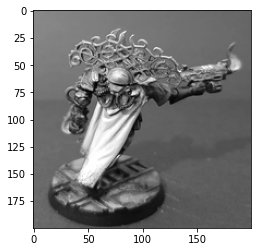

In [99]:
# image recreations
import matplotlib.pyplot as plt
import matplotlib.cm as cm

plt.imshow(np.array(images[5][0]), cmap=cm.gray)
#np.array(images[5]) # float values

In [100]:
# define the standalone discriminator model
def define_discriminator(in_shape=(200,200,1)):
	model = Sequential()
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same', input_shape=in_shape))
	model.add(LeakyReLU(alpha=0.2))
	# downsample
	model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# classifier
	model.add(Flatten())
	model.add(Dropout(0.4))
	model.add(Dense(1, activation='sigmoid'))
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

In [101]:
def define_generator(latent_dim):
	model = Sequential()
	# foundation for 50x50 image
	n_nodes = 128 * 50 * 50
	model.add(Dense(n_nodes, input_dim=latent_dim))
	model.add(LeakyReLU(alpha=0.2))
	model.add(Reshape((50, 50, 128)))
	# upsample to 100x100
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# upsample to 200x200
	model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
	model.add(LeakyReLU(alpha=0.2))
	# generate
	model.add(Conv2D(1, (50,50), activation='tanh', padding='same'))
	return model

In [102]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(generator, discriminator):
	# make weights in the discriminator not trainable
	discriminator.trainable = False
	# connect them
	model = Sequential()
	# add generator
	model.add(generator)
	# add the discriminator
	model.add(discriminator)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

In [103]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	x_input = x_input.reshape(n_samples, latent_dim)
	return x_input

In [104]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	x_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	X = generator.predict(x_input)
	# create class labels
	y = zeros((n_samples, 1))
	return X, y

In [170]:
# select real samples
def generate_real_samples(datasetIn, n_samples):
	# choose random instances
	ix = randint(0, datasetIn.shape[0], n_samples)
	# select images
	X = datasetIn[ix][0], y = ones((n_samples, 1))
	# generate class labels
	# y = ones((n_samples, 1))
	return X, y

In [171]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=10, n_batch=4):
	bat_per_epo = int(dataset.shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			X_real, y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch(X_real, y_real)
			# generate 'fake' examples
			X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)
			# prepare points in latent space as input for the generator
			X_gan = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch(X_gan, y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('generator.h5')

In [169]:
# size of the latent space
latent_dim = 100
# create the discriminator
discriminator = define_discriminator()
# create the generator
generator = define_generator(latent_dim)
# create the gan
gan_model = define_gan(generator, discriminator)
# load image data
dataset = X_training
# train model
train(generator, discriminator, gan_model, dataset, latent_dim)

ValueError: ValueError: could not broadcast input array from shape (200,200) into shape (2)

In [147]:
dataset[0]

array([array([[0.5254902 , 0.5254902 , 0.5254902 , ..., 0.39215687, 0.39215687,
        0.39215687],
       [0.5254902 , 0.5254902 , 0.5254902 , ..., 0.39215687, 0.39215687,
        0.39215687],
       [0.52156866, 0.52156866, 0.5254902 , ..., 0.39607844, 0.39607844,
        0.39607844],
       ...,
       [0.4627451 , 0.45882353, 0.4627451 , ..., 0.3882353 , 0.36862746,
        0.36078432],
       [0.45882353, 0.45882353, 0.4627451 , ..., 0.38039216, 0.37254903,
        0.3647059 ],
       [0.4627451 , 0.4627451 , 0.45882353, ..., 0.3764706 , 0.38039216,
        0.37254903]], dtype=float32),
       1], dtype=object)